# Nasdaq Composite 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'IXIC'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='1y', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-04-01 00:00:00-04:00,16397.050781,16490.650391,16327.889648,16396.830078,4798390000,0.0,0.0
2024-04-02 00:00:00-04:00,16199.240234,16251.410156,16137.240234,16240.450195,4710280000,0.0,0.0
2024-04-03 00:00:00-04:00,16178.799805,16340.740234,16169.309570,16277.459961,5151500000,0.0,0.0
2024-04-04 00:00:00-04:00,16418.570312,16468.039062,16046.559570,16049.080078,5368700000,0.0,0.0
2024-04-05 00:00:00-04:00,16095.400391,16326.500000,16080.480469,16248.519531,4578130000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-24 00:00:00-04:00,18046.189453,18210.050781,18030.679688,18188.589844,6787790000,0.0,0.0
2025-03-25 00:00:00-04:00,18207.970703,18281.130859,18170.419922,18271.859375,6475790000,0.0,0.0
2025-03-26 00:00:00-04:00,18217.330078,18236.550781,17837.259766,17899.019531,9091510000,0.0,0.0


In [3]:
df0 = ticker.history(period='3y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-29 00:00:00-04:00,14500.389648,14646.900391,14419.400391,14619.639648,6060890000,0.0,0.0
2022-03-30 00:00:00-04:00,14558.589844,14609.250000,14383.450195,14442.269531,5479200000,0.0,0.0
2022-03-31 00:00:00-04:00,14444.780273,14456.740234,14217.719727,14220.519531,5453890000,0.0,0.0
2022-04-01 00:00:00-04:00,14269.530273,14306.940430,14131.809570,14261.500000,5002790000,0.0,0.0
2022-04-04 00:00:00-04:00,14304.349609,14534.379883,14286.450195,14532.549805,4630100000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-24 00:00:00-04:00,18046.189453,18210.050781,18030.679688,18188.589844,6787790000,0.0,0.0
2025-03-25 00:00:00-04:00,18207.970703,18281.130859,18170.419922,18271.859375,6475790000,0.0,0.0
2025-03-26 00:00:00-04:00,18217.330078,18236.550781,17837.259766,17899.019531,9091510000,0.0,0.0


## Moving Median

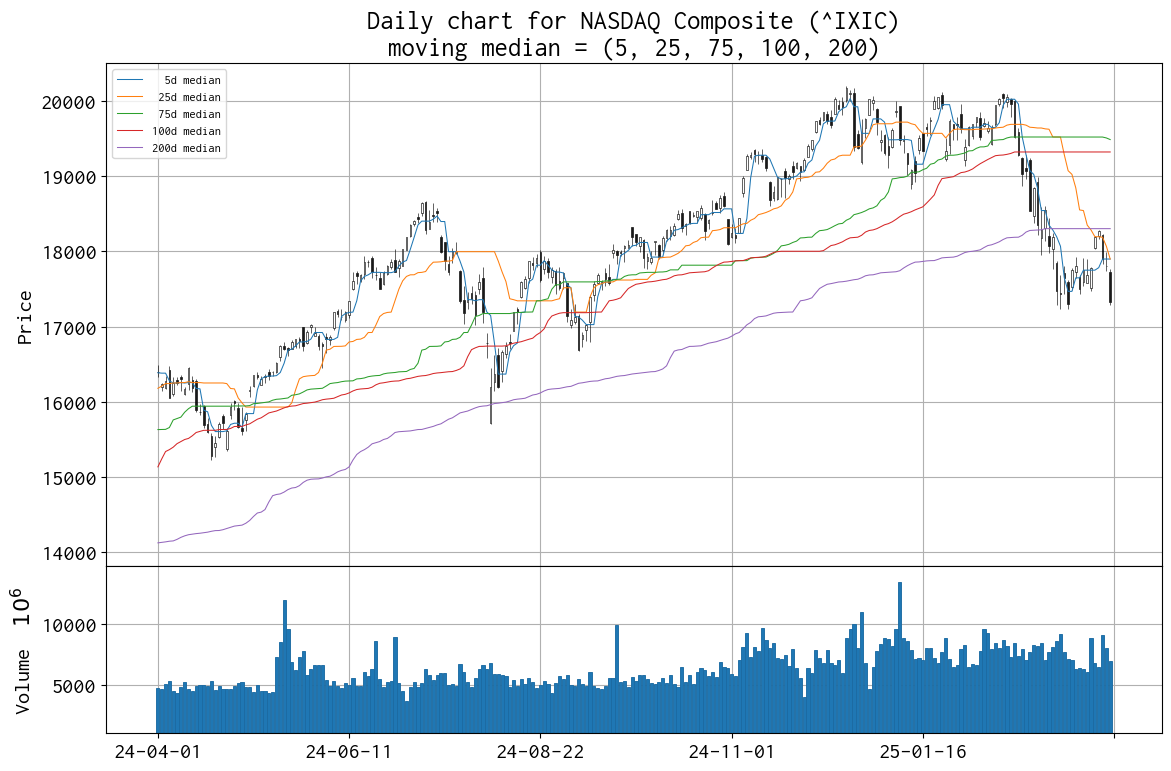

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax[0]),
]   

mpf.plot(
    df, type='candle', style='default',
    volume=ax[1],
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)
ax[0].set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax[0].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-27 00:00:00-04:00,17811.240234,17988.019531,17743.800781,17804.029297,8002470000,0.0,0.0
2025-03-28 00:00:00-04:00,17722.089844,17763.279297,17283.060547,17322.990234,7015410000,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-27 00:00:00-04:00    17804.029297
2025-03-28 00:00:00-04:00    17322.990234
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-27 00:00:00-04:00           NaN
2025-03-28 00:00:00-04:00   -481.039062
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-28 00:00:00-04:00   -399.099609
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-03-24 00:00:00-04:00    17750.789062
2025-03-25 00:00:00-04:00    17754.089844
2025-03-26 00:00:00-04:00    17784.050781
2025-03-27 00:00:00-04:00    17804.029297
2025-03-28 00:00:00-04:00    17784.050781
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-03-24 00:00:00-04:00    17750.789062
2025-03-25 00:00:00-04:00    17750.789062
2025-03-26 00:00:00-04:00    17750.789062
2025-03-27 00:00:00-04:00    17754.089844
2025-03-28 00:00:00-04:00    17754.089844
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-03-24 00:00:00-04:00    18240.690430
2025-03-25 00:00:00-04:00    18234.040039
2025-03-26 00:00:00-04:00    18192.405273
2025-03-27 00:00:00-04:00    18128.924805
2025-03-28 00:00:00-04:00    17984.139648
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-03-24 00:00:00-04:00    19366.895508
2025-03-25 00:00:00-04:00    19340.059570
2025-03-26 00:00:00-04:00    19312.609375
2025-03-27 00:00:00-04:00    19312.609375
2025-03-28 00:00:00-04:00    19312.609375
Name: Close, dtype: float64

## Robust Bollinger's bands

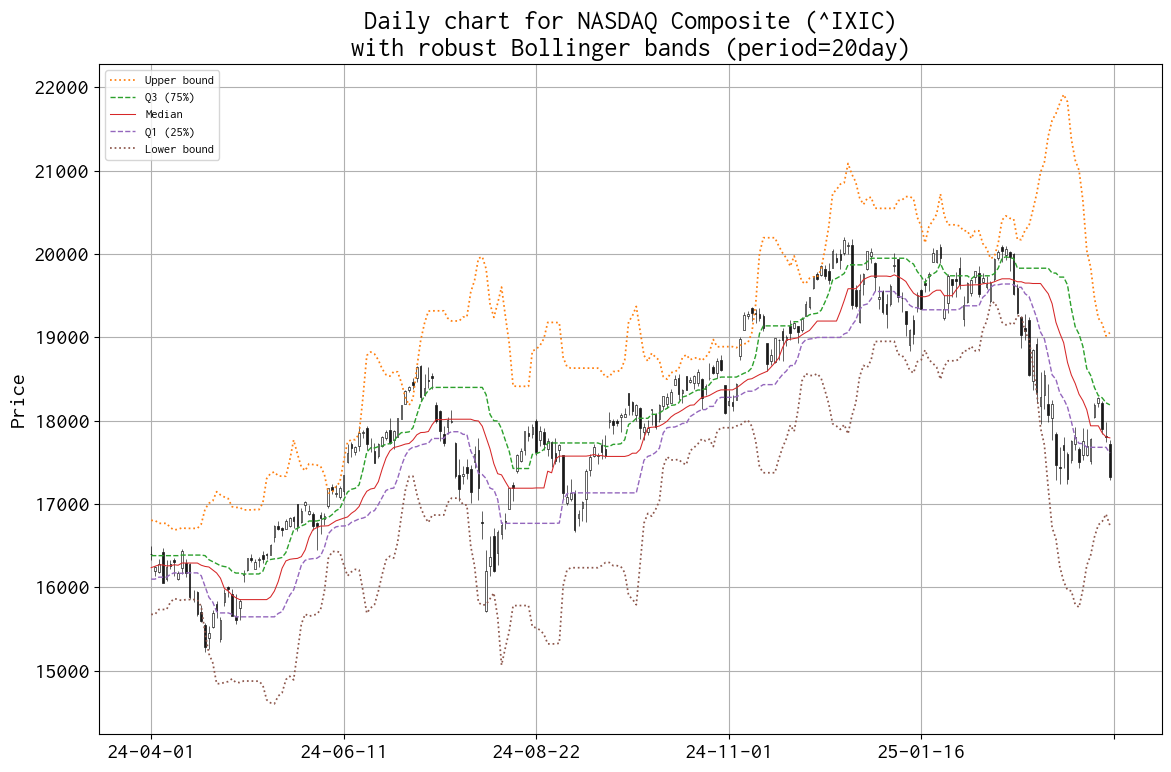

In [13]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%dday)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%dday)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

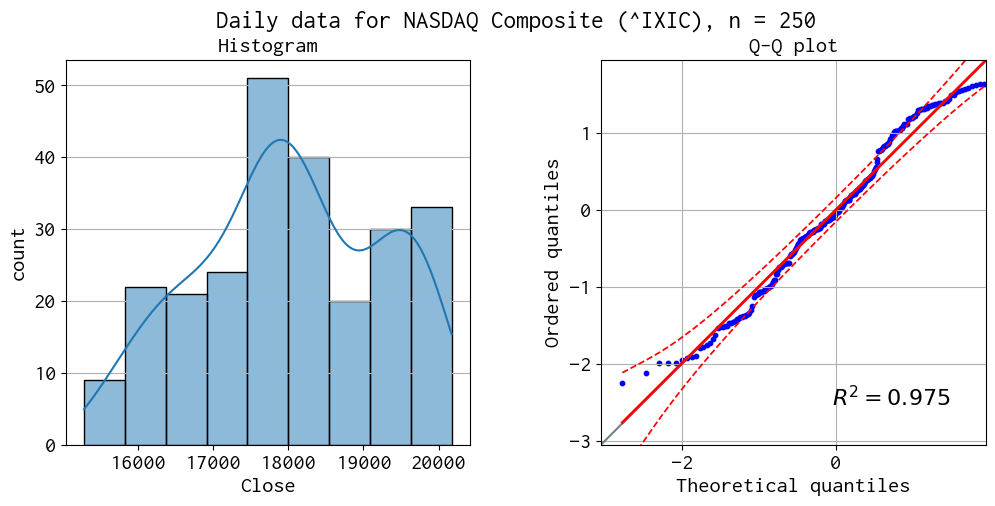

In [14]:
plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()